In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:

# Load the training set from a CSV file
X_train = pd.read_csv('../data/X_train_balanceado.csv')
y_train = pd.read_csv('../data/y_train_balanceado.csv')

# Load the test set from a CSV file
X_test = pd.read_csv('../data/X_test_balanceado.csv')
y_test = pd.read_csv('../data/y_test_balanceado.csv')

In [3]:

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Scale the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
import joblib

# Save the scaler object to a file
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [4]:
y_train = np.array(y_train.values)
y_test = np.array(y_test.values)

In [5]:


# Define the custom F1 score metric
def f1_m(y_true, y_pred):
    y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]
    return f1_score(y_true, y_pred_binary)

# Convert the data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)




In [35]:
# Define the parameters for XGBoost
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}

# Use grid search to find the optimal hyperparameters
grid_params = {
    'max_depth': [8, 10],
    'min_child_weight': [3, 5],
    'subsample': [ 0.8],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(**params),
                           param_grid=grid_params,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, max_depth=8, min_child_weight=5, subsample=0.8; total time= 1.4min
[CV] END colsample_bytree=0.6, max_depth=8, min_child_weight=5, subsample=0.8; total time= 1.4min
[CV] END colsample_bytree=0.6, max_depth=8, min_child_weight=3, subsample=0.8; total time= 1.4min
[CV] END colsample_bytree=0.6, max_depth=8, min_child_weight=3, subsample=0.8; total time= 1.4min
[CV] END colsample_bytree=0.6, max_depth=8, min_child_weight=3, subsample=0.8; total time= 1.4min
[CV] END colsample_bytree=0.6, max_depth=8, min_child_weight=5, subsample=0.8; total time= 1.4min
[CV] END colsample_bytree=0.6, max_depth=10, min_child_weight=5, subsample=0.8; total time= 1.7min
[CV] END colsample_bytree=0.6, max_depth=10, min_child_weight=3, subsample=0.8; total time= 1.7min
[CV] END colsample_bytree=0.6, max_depth=10, min_child_weight=3, subsample=0.8; total time= 1.7min
[CV] END colsample_bytree=0.6, max_depth=10, min_child

In [36]:
print('Best parameters found by grid search are:', best_params)

Best parameters found by grid search are: {'colsample_bytree': 0.6, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.8}


In [6]:
params = {
    'colsample_bytree': 0.6,
    'max_depth': 8,
    'min_child_weight': 5, 
    'subsample': 0.8,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

In [7]:
# Train the XGBoost model with the optimal hyperparameters
model = xgb.train(params, dtrain, num_boost_round=1000,
                  early_stopping_rounds=20,
                  evals=[(dtest, 'test')],verbose_eval=10 )

[0]	test-error:0.32373
[10]	test-error:0.33283
[20]	test-error:0.33661


In [8]:
# Save the trained model to a file
model.save_model('xgboost_model.bin')

In [10]:
y_pred = model.predict(dtest)

# Convert the predicted probabilities to binary labels
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the accuracy, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

Accuracy: 0.66, Recall: 0.66, F1 score: 0.77


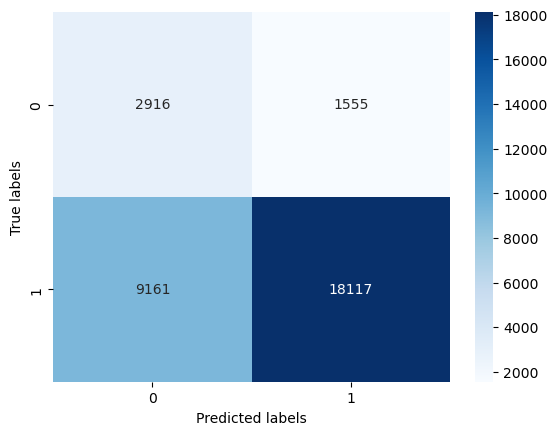

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

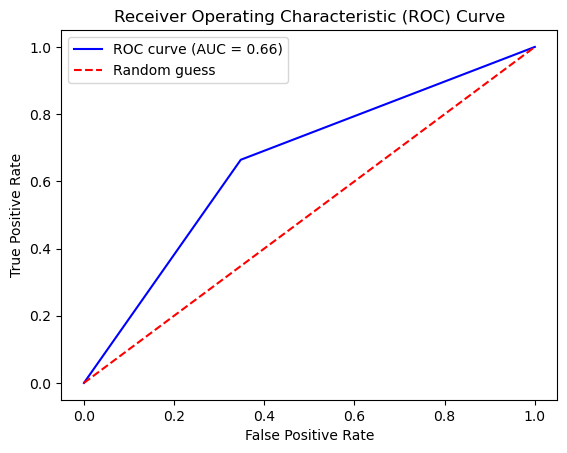

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, 'b-', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()